# Mean Reversion on pairs

## Find best pair to trade 

### Import libraries and data

In [21]:
from dataToDictionnary import *
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import seaborn as sns

exchanges = ['binance']
used_pairs = ['LRC/USDT', 'SNX/USDT', 'KNC/USDT', 'BNT/USDT', 'REN/USDT', 'ENJ/USDT', 'ETH/USDT']
durations = ['3m']
exec(open("02-refreshDataCandles-fast.py").read())
data = dataToDico(used_pairs, durations, exchanges)
df=pd.DataFrame.from_dict(data, orient='index')
    
df = df.transpose()
df=df.dropna()
df['time'] = pd.to_datetime(df['time'],unit='ms')
for pair in used_pairs:
    df = df[df[pair]!=0]

df = df.reset_index()

df.set_index('time', inplace=True, drop=True)

### Run cointegration test

In [35]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

We do a Dickey Fuller test to find a pair of asset which a linear combination of the prices is stationary.

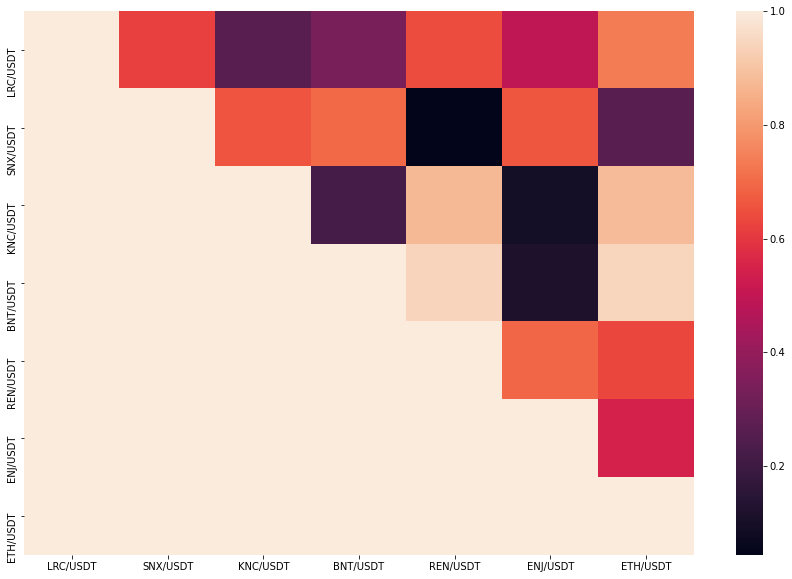

In [36]:
#set up the split point for our "training data" on which to perform the co-integration test (the remaining dat awill be fed to our backtest function)
split = int(len(df) * .4)
#run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix,pairs = find_cointegrated_pairs(df[:split])
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pvalue_matrix_df,xticklabels=used_pairs,yticklabels=used_pairs,ax=ax)

So we can see there are indeed a few pairs of stocks who’s co-integration score seems below the 5% threshold : SNX/REN and KNC/ENJ 

## Backtest

### Import data and libraries

In [22]:
from dataToDictionnary import *
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import time

# Load the prices data for 2 assets

exchanges = ['binance']
pairs = ['SNX/USDT','REN/USDT']
durations = ['3m']

data = dataToDico(pairs, durations, exchanges)
df=pd.DataFrame.from_dict(data, orient='index')

df = df.transpose()
df=df.dropna()
df['time'] = pd.to_datetime(df['time'],unit='ms')
df = df[df[pairs[0]]!=0]
df = df[df[pairs[1]]!=0]
df = df.reset_index()

df.set_index('time')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96848 entries, 0 to 96847
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     96848 non-null  int64         
 1   time      96848 non-null  datetime64[ns]
 2   SNX/USDT  96848 non-null  float64       
 3   REN/USDT  96848 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 3.0 MB
None


### Compute indicators

In [27]:
from statsmodels.regression.rolling import RollingOLS

def calculate_spread_zscore(df,lookback=100):
    #print("Fitting the rolling Linear Regression...")
    y=df[pairs[0]]
    x=df[pairs[1]]

    model = RollingOLS(x,y, lookback).fit()

    # Construct the hedge ratio and eliminate the first 
    # lookback-length empty/NaN period
    df['hedge_ratio'] = model.params
    df = df.dropna()

    # Create the spread and then a z-score of the spread
    #print("Creating the spread/zscore columns...")
    
    
    df['spread'] = df[pairs[0]] - df['hedge_ratio']*df[pairs[1]]
    
    df['zscore'] = (df['spread'] - df['spread'].rolling(lookback).mean()) / df['spread'].rolling(lookback).std()
    return df


### Define positions (long/short)

In [28]:
# mr_spy_iwm.py

def create_long_short_market_signals(df, 
                                     z_entry_threshold=2.0, 
                                     z_exit_threshold=1.0):

    

    # Calculate when to be long, short and when to exit
    df['longs'] = (df['zscore'] <= -z_entry_threshold)*1.0
    df['shorts'] = (df['zscore'] >= z_entry_threshold)*1.0
    df['exits'] = (np.abs(df['zscore']) <= z_exit_threshold)*1.0
    # These signals are needed because we need to propagate a
    # position forward, i.e. we need to stay long if the zscore    
    # threshold is less than z_entry_threshold by still greater
    # than z_exit_threshold, and vice versa for shorts.
    df['long_market'] = 0.0
    df['short_market'] = 0.0

    # These variables track whether to be long or short while
    # iterating through the bars
    long_market = 0
    short_market = 0

    # Calculates when to actually be "in" the market, i.e. to have a
    # long or short position, as well as when not to be.
    # Since this is using iterrows to loop over a dataframe, it will
    # be significantly less efficient than a vectorised operation,
    # i.e. slow!
    #print("Calculating when to be in the market (long and short)...")
    for i, b in (df.iterrows()):
        # Calculate longs
        if b['longs'] == 1.0:
            long_market = 1            
        # Calculate shorts
        if b['shorts'] == 1.0:
            short_market = 1
        # Calculate exists
        if b['exits'] == 1.0:
            long_market = 0
            short_market = 0
        # This directly assigns a 1 or 0 to the long_market/short_market
        # columns, such that the strategy knows when to actually stay in!
        #df.loc[i]['long_market'] = long_market
        df.at[i, 'long_market'] = long_market
        df.at[i, 'short_market'] = short_market
    return df

### Compute returns

In [29]:
# mr_spy_iwm.py

def create_portfolio_returns(df):
    """Creates a portfolio pandas DataFrame which keeps track of
    the account equity and ultimately generates an equity curve.
    This can be used to generate drawdown and risk/reward ratios."""
    
    
    #print("Constructing a portfolio...")
    portfolio = pd.DataFrame(index=df.index)
    portfolio['positions'] = df['long_market'] - df['short_market']
    portfolio[pairs[0]] = -1.0 * df[pairs[0]] * portfolio['positions']
    portfolio[pairs[1]] = df[pairs[1]] * portfolio['positions']
    portfolio['total'] = portfolio[pairs[0]] + portfolio[pairs[1]]

    # Construct a percentage returns stream and eliminate all 
    # of the NaN and -inf/+inf cells
    #print("Constructing the equity curve...")
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1.0, 0.0, inplace=True)

    # Calculate the full equity curve
    portfolio['returns'] = (portfolio['returns'] + 1.0).cumprod()

    return portfolio

Calculating lookback=50...
Calculating lookback=60...
Calculating lookback=70...
Calculating lookback=80...
Calculating lookback=90...
Calculating lookback=100...
Calculating lookback=110...
Calculating lookback=120...
Calculating lookback=130...
Calculating lookback=140...
Calculating lookback=150...
Calculating lookback=160...
Calculating lookback=170...
Calculating lookback=180...
Calculating lookback=190...
Calculating lookback=200...
Calculating lookback=210...
Calculating lookback=220...
Calculating lookback=230...
Calculating lookback=240...
Calculating lookback=250...
Calculating lookback=260...
Calculating lookback=270...
Calculating lookback=280...
Calculating lookback=290...
Calculating lookback=300...
Calculating lookback=310...
Calculating lookback=320...
Calculating lookback=330...
Calculating lookback=340...
Calculating lookback=350...
Calculating lookback=360...
Calculating lookback=370...
Calculating lookback=380...
Calculating lookback=390...
Calculating lookback=400.

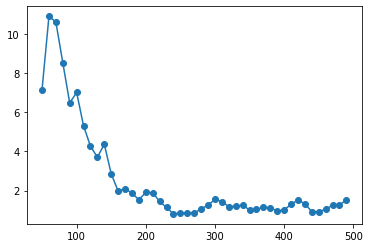

In [30]:
lookbacks = range(50, 500, 10)
returns = []
exchanges = ['binance']
pairs = ['SNX/USDT','REN/USDT']
durations = ['3m']

data = dataToDico(pairs, durations, exchanges)
# Adjust lookback period from 50 to 500 in increments
# of 10 in order to produce sensitivities
for lb in lookbacks: 
    
    df=pd.DataFrame.from_dict(data, orient='index')

    df = df.transpose()
    df=df.dropna()
    df['time'] = pd.to_datetime(df['time'],unit='ms')
    df = df[df[pairs[0]]!=0]
    df = df[df[pairs[1]]!=0]
    df = df.reset_index()

    df.set_index('time')

    print("Calculating lookback=%s..." % lb)
    df = calculate_spread_zscore(df, lookback=lb)
    df = create_long_short_market_signals(df, 
                                            z_entry_threshold=2.0, 
                                            z_exit_threshold=1.0)
    portfolio = create_portfolio_returns(df)
    returns.append(portfolio.iloc[-1]['returns'])

print("Plot the lookback-performance scatterchart...")
plt.plot(lookbacks, returns, '-o')
#plt.ylabel('returns')
#plt.xlabel('lookbacks')
plt.show()


In [34]:
data = dataToDico(pairs, durations, exchanges)
df=pd.DataFrame.from_dict(data, orient='index')

df = df.transpose()
df=df.dropna()
df['time'] = pd.to_datetime(df['time'],unit='ms')
df = df[df[pairs[0]]!=0]
df = df[df[pairs[1]]!=0]
df = df.reset_index()

df.set_index('time')

,index,SNX/USDT,REN/USDT
time,,,
2020-07-09 12:03:00,86380,3.398,0.18616
2020-07-09 12:06:00,86381,3.131,0.18621
2020-07-09 12:09:00,86382,3.177,0.18616
2020-07-09 12:12:00,86383,3.161,0.18616
2020-07-09 12:15:00,86384,3.169,0.18643
...,...,...,...
2021-01-27 12:03:00,183223,15.590,0.55503
2021-01-27 12:06:00,183224,15.891,0.56178
2021-01-27 12:09:00,183225,15.739,0.56071


return for mean reversion pairs strategy :  647.9550238875167 %


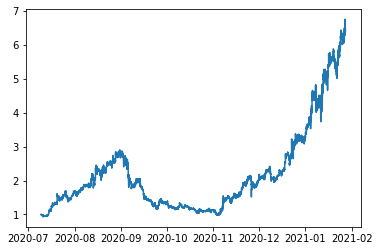

return for buy and hold strategy :  521.4666666666667 %


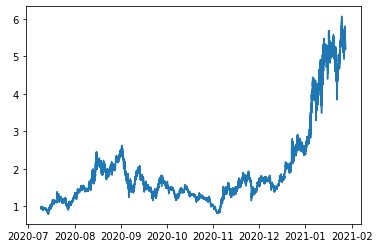

In [35]:
#seems that optimal lookback  is 90
# so we visualize returns for lookback = 90
lookback = 90
df = calculate_spread_zscore(df, lookback)
    
df = create_long_short_market_signals(df, 2.0, 1.0)
#print(df.loc[df['long_market']==1].count())
portfolio = create_portfolio_returns(df)
print('return for mean reversion pairs strategy : ',portfolio.iloc[-1]['returns']*100, '%')
df['buyAndHold']=df[pairs[0]]/df[pairs[0]][lookback]

plt.plot(df['time'], portfolio['returns'])
plt.title = ('returns for mean reversion pairs')
plt.ylabel = ('return')
#fig.autofmt_xdate()
plt.show()

print('return for buy and hold strategy : ', df.iloc[-1]['buyAndHold']*100, '%')
plt.figure()
plt.plot(df['time'], df[pairs[0]]/df[pairs[0]][lookback])
plt.title = ('returns for buy and hold')
plt.ylabel = ('return')
plt.show()

## Trading in live

Launch all cells beyond this point to run code in live

In [31]:

def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [32]:
from statsmodels.regression.rolling import RollingOLS

"""Creates a hedge ratio between the two pairs by calculating
    a rolling linear regression with a defined lookback period. This
    is then used to create a z-score of the 'spread' between the two
    pairs based on a linear combination of the two."""
def calculate_spread_zscore(df,lookback=100):
    print("Fitting the rolling Linear Regression...")
    y=df[pairs[0]]
    x=df[pairs[1]]

    model = RollingOLS(x,y, lookback).fit()

    # Construct the hedge ratio and eliminate the first 
    # lookback-length empty/NaN period
    df['hedge_ratio'] = model.params
    df = df.dropna()

    # Create the spread and then a z-score of the spread
    print("Creating the spread/zscore columns...")
    
    df['spread'] = df[pairs[0]] - df['hedge_ratio']*df[pairs[1]]
    #df = df.reset_index()
    #halflife = half_life(df['spread'])
    df['zscore'] = (df['spread'] - df['spread'].rolling(lookback).mean()) / df['spread'].rolling(lookback).std()
    return df


In [33]:
def get_keys(filename):
    with open(filename, mode='r', encoding='utf-8') as keys:
        for key in keys:
            apiKey = key.split()[0]
            secretKey = key.split()[1]
    return apiKey, secretKey

### Adapt strategy to live

In [40]:

def deploy_live(df, pairs, dep, zentry_threshold, zexit_threshold, totalShort0, totalLong0, totalShort1, totalLong1) :
    
    #print(pairs)
    pair0 = pairs[0].replace("/", "")
    pair1 = pairs[1].replace("/", "")
    print(pair0)
    if df.iloc[-1]["zscore"] >= zentry_threshold:
        amountToTrade1 = dep/2/df.iloc[-1][pairs[0]]
        amountToTrade1 = truncate(amountToTrade1, 0)
        amountToTrade2 = dep/2/df.iloc[-1][pairs[1]]
        amountToTrade2 = truncate(amountToTrade2, 0)
        short = request_client.post_order(symbol=pair1, side=OrderSide.SELL, ordertype=OrderType.MARKET, quantity=amountToTrade2, positionSide="SHORT")
        long = request_client.post_order(symbol=pair0, side=OrderSide.BUY, ordertype=OrderType.MARKET,quantity=amountToTrade1, positionSide="LONG")
        totalLong0 += amountToTrade1
        totalShort1 += amountToTrade2
    if df.iloc[-1]["zscore"] <= -1*zentry_threshold:
        amountToTrade1 = dep/2/df.iloc[-1][pairs[0]]
        amountToTrade1 = truncate(amountToTrade1, 0)
        amountToTrade2 = dep/2/df.iloc[-1][pairs[1]]
        amountToTrade2 = truncate(amountToTrade2, 0)
        short = request_client.post_order(symbol=pair0, side=OrderSide.SELL, ordertype=OrderType.MARKET, quantity=amountToTrade1, positionSide="SHORT")
        long = request_client.post_order(symbol=pair1, side=OrderSide.BUY, ordertype=OrderType.MARKET,quantity=amountToTrade2, positionSide="LONG")
        totalShort0 += amountToTrade1
        totalLong1 += amountToTrade2
    if df.iloc[-1]["zscore"] <= zexit_threshold and df.iloc[-1]["zscore"]>= -1*zexit_threshold and (totalShort0 > 0) :
        closeShort = request_client.post_order(symbol=pair0, side=OrderSide.BUY, ordertype=OrderType.MARKET, quantity=totalShort0, positionSide="SHORT")
        closeLong = request_client.post_order(symbol=pair1, side=OrderSide.SELL, ordertype=OrderType.MARKET,quantity=totalLong1, positionSide="LONG")
        totalShort0 = 0
        totalLong1 = 0
    if df.iloc[-1]["zscore"] <= zexit_threshold and df.iloc[-1]["zscore"]>= -1*zexit_threshold and (totalLong0 > 0) :
        closeLong = request_client.post_order(symbol=pair0, side=OrderSide.SELL, ordertype=OrderType.MARKET, quantity=totalLong0, positionSide="LONG")
        closeShort = request_client.post_order(symbol=pair1, side=OrderSide.BUY, ordertype=OrderType.MARKET,quantity=totalShort1, positionSide="SHORT")
        totalLong0 = 0
        totalShort1 = 0
        
    return totalShort0, totalLong0, totalShort1, totalLong1

### Main

In [ ]:
from dataToDictionnary import *
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import time
import math
from binance_f import RequestClient
from binance_f.constant.test import *
from binance_f.base.printobject import *
from binance_f.model.constant import *
import requests
import os

API_KEY, SECRET_KEY = get_keys('keys.txt') 

url = "https://fapi.binance.com/"
request_client = RequestClient(api_key=API_KEY, secret_key=SECRET_KEY, url = "https://fapi.binance.com/")
dep = 59
zexit_threshold = 0.5
zentry_threshold = 1.5
lookback = 80
# Load the prices data for 2 assets
i = 0
totalShort0, totalLong0, totalShort1, totalLong1 = 0,0,0,0
while True :
    
    print("Collecting data...")
    
    exec(open("02-refreshDataCandles-fast.py").read())
    print("Storing data in dataframe...")
    exchanges = ['binance']
    pairs = ['SNX/USDT','REN/USDT']
    durations = ['3m']
    data = dataToDico(pairs, durations, exchanges)
    df=pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    df=df.dropna()
    df['time'] = pd.to_datetime(df['time'],unit='ms')
    df = df[df[pairs[0]]!=0]
    df = df[df[pairs[1]]!=0]
    df = df.reset_index()
    
    df.set_index('time')
    
    df = calculate_spread_zscore(df, lookback)
    print(df.iloc[-1])
    totalShort0, totalLong0, totalShort1, totalLong1 = deploy_live(df, pairs, dep, zentry_threshold, zexit_threshold, totalShort0, totalLong0, totalShort1, totalLong1)
    print("Waiting for next exec...\n")
    time.sleep(150)
    i+=1